In [1]:
import os
import numpy as np 

In [27]:
import torch

In [2]:
import astropy.io.fits as fits
from astropy.table import Table

In [3]:
import matplotlib.pyplot as plt

In [4]:
qsos = Table.read('/global/cfs/cdirs/desi/users/sgontcho/lya/spender-lya/QSO_cat_iron_main_dark_healpix_BAL_n_DLA_cuts.fits')

In [5]:
qsos

TARGETID,Z,ZERR,ZWARN,SPECTYPE,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,PROBA_RF,MASKBITS,DESI_TARGET,SCND_TARGET,COADD_NUMEXP,COADD_EXPTIME,CMX_TARGET,SV1_DESI_TARGET,SV2_DESI_TARGET,SV3_DESI_TARGET,SV1_SCND_TARGET,SV2_SCND_TARGET,SV3_SCND_TARGET,TSNR2_LYA,TSNR2_QSO,DELTA_CHI2_MGII,A_MGII,SIGMA_MGII,B_MGII,VAR_A_MGII,VAR_SIGMA_MGII,VAR_B_MGII,Z_RR,Z_QN,C_LYA,C_CIV,C_CIII,C_MgII,C_Hbeta,C_Halpha,Z_LYA,Z_CIV,Z_CIII,Z_MgII,Z_Hbeta,Z_Halpha,QSO_MASKBITS,HPXPIXEL,SURVEY,PROGRAM,TSNR2_ELG,TSNR2_LRG,COADD_FIRSTNIGHT,COADD_FIRSTMJD,COADD_LASTNIGHT,COADD_LASTMJD,COADD_MEANMJD
int64,float64,float64,int64,bytes6,int32,float64,float64,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,int16,int64,int64,int16,float32,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int64,bytes4,bytes4,float32,float32,int32,float64,int32,float64,float64
39627322705320844,1.5713073987738557,0.0014999521540232073,0,QSO,0,22.165120364661878,-19.38537156552792,PSF,0.017960213,1.1324737,1.5004861,1.7412343,4.011333,4.500382,3136.2085,1885.5708,236.65141,3.2900584,0.7179032,0.941645749090258,0.941645749090258,0.941645749090258,0.941645749090258,0.941645749090258,0.9318075056225061,0,262148,0,1,1153.1862,0,0,0,0,0,0,0,104.638,26.887552,3.3660061,228.93489,3221.6318,-228.58391,361530750000.0,18537934000000.0,361530750000.0,1.5713074,1.537752,0.011531864,0.93428963,0.9522595,0.9903967,0.00037662507,0.0038649805,2.2635436,1.5853727,1.5395349,1.537752,0.44332844,0.45995685,10,16725,main,dark,103.4601,75.42169,20211031,59519.27405421,20211031,59519.27405421,59519.27405421
39627322705321907,1.527567040158152,0.0007580640825158279,0,QSO,0,22.19615939639026,-19.388861440289986,PSF,0.01763974,0.41055256,0.827046,0.87341857,8.023462,14.939849,3051.1602,1820.7067,205.2426,3.15029,0.67557544,0.9426565479342709,0.9426565479342709,0.9426565479342709,0.9426565479342709,0.9426565479342709,0.9423788779228925,0,4611686018427650052,34359738368,1,1153.1862,0,0,0,0,0,0,0,108.88162,26.839125,0.5047134,0.24716042,-30.076565,0.5497762,0.0016672083,40.327793,0.00053593516,1.527567,1.5284766,1.7597084e-05,1.0,0.9999935,0.9999969,1.0364874e-06,5.6991375e-06,2.2028666,1.5284766,1.5243,1.5246962,0.090027876,0.45464784,10,16725,main,dark,102.996826,74.96286,20211031,59519.27405421,20211031,59519.27405421,59519.27405421
39627322709514577,1.868373695807174,0.0025263119023293257,4,QSO,0,22.409658386562008,-19.388786997297064,PSF,0.018412018,0.33502603,0.64236677,1.1866152,6.8170924,6.2368255,3794.662,2546.042,276.914,3.2606125,0.71421623,0.9402225617501284,0.9402225617501284,0.9402225617501284,0.9402225617501284,0.9402225617501284,0.8621434867531061,0,262148,0,1,1153.1862,0,0,0,0,0,0,0,97.388466,24.787659,--,--,--,--,--,--,--,0.17725836,1.8235803,0.00017663962,0.9613777,0.05009007,0.10592867,5.0051467e-06,2.3625212e-06,3.1913922,1.8235803,1.7609049,1.7693188,0.41932172,0.1894294,26,17408,main,dark,95.527214,70.10903,20211031,59519.27405421,20211031,59519.27405421,59519.27405421
39627328392794748,1.3103639161104224,0.001369306435066525,0,QSO,0,21.025564410792047,-19.157535498555323,PSF,0.02948575,0.7520727,0.94289964,0.98479915,3.7379165,6.12323,3147.2085,2096.8591,226.70918,3.4932954,0.741959,0.9060048277962384,0.9060048277962384,0.9060048277962384,0.9060048277962384,0.9060048277962384,0.9799487203359604,0,262148,0,1,1153.1862,0,0,0,0,0,0,0,48.341537,27.408562,19.906557,0.3598753,-13.491808,0.22666256,0.0051199687,8.682532,0.0003640458,1.3103639,1.3119448,5.214265e-05,0.00046102682,0.53128207,0.15900025,0.0001097387,1.1755284e

(0.0, 4.0)

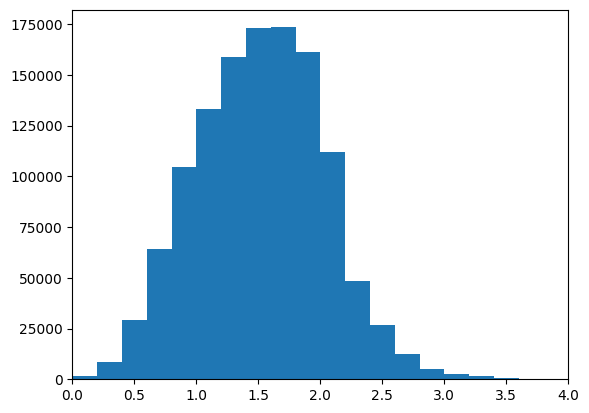

In [6]:
plt.hist(qsos['Z'], range=[0, 4.], bins=20)
plt.xlim(0., 4.)

# lets take a look a couple spectra

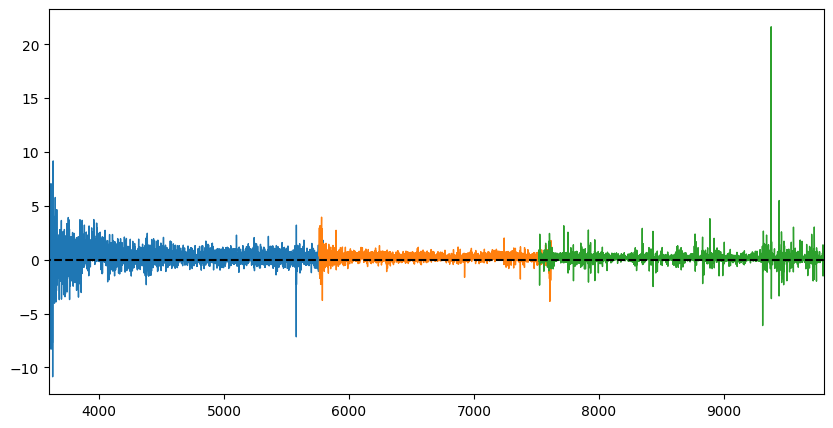

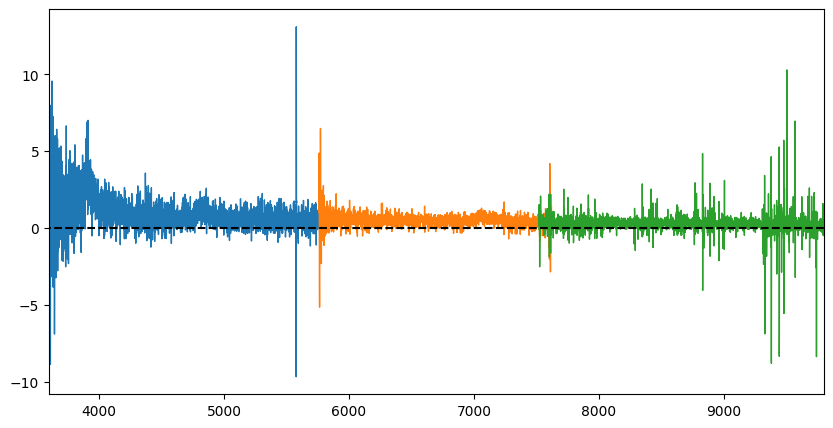

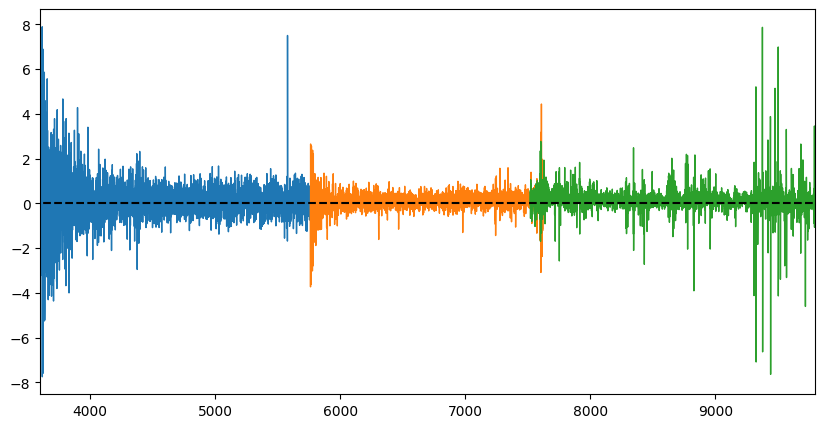

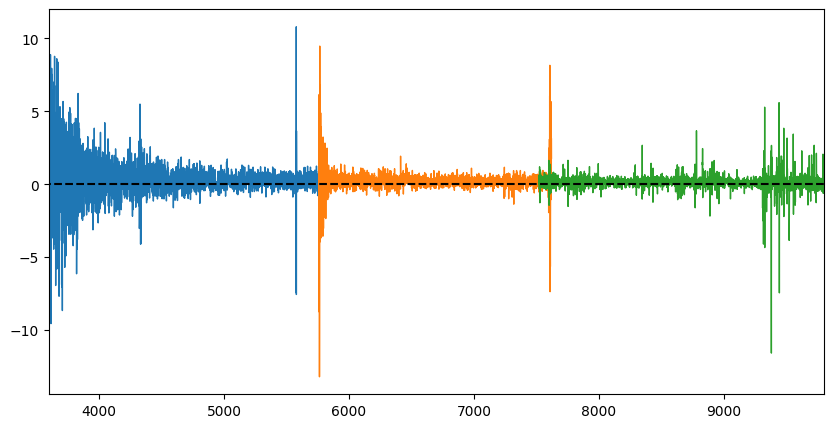

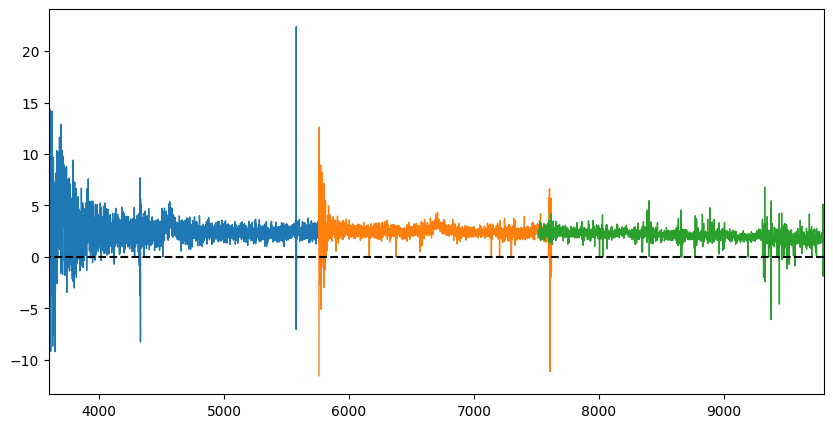

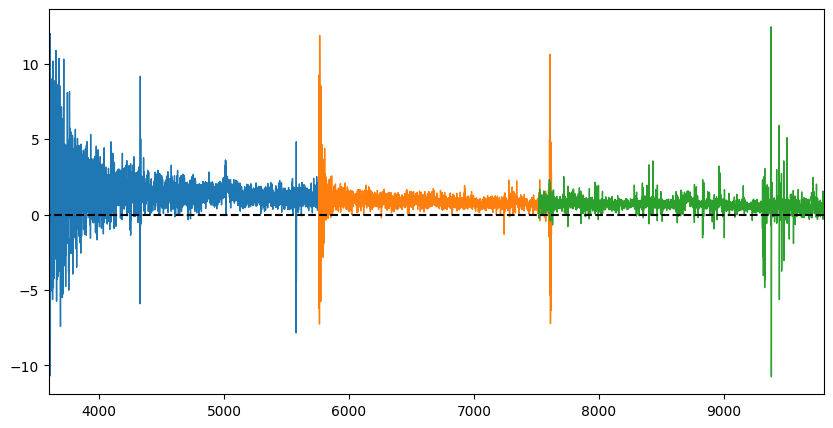

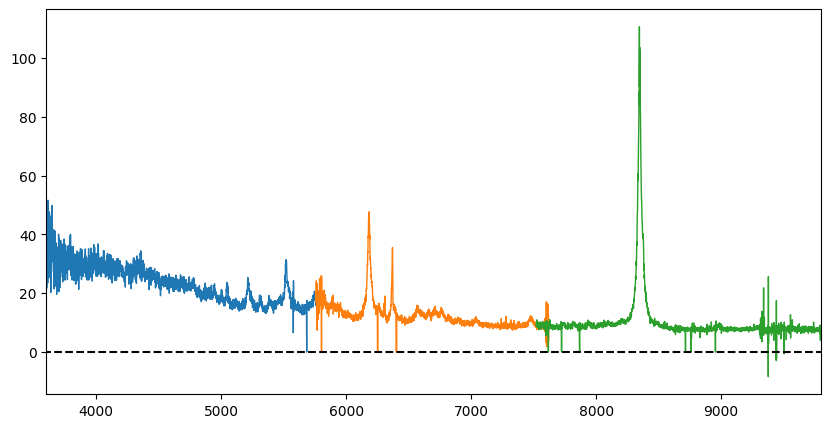

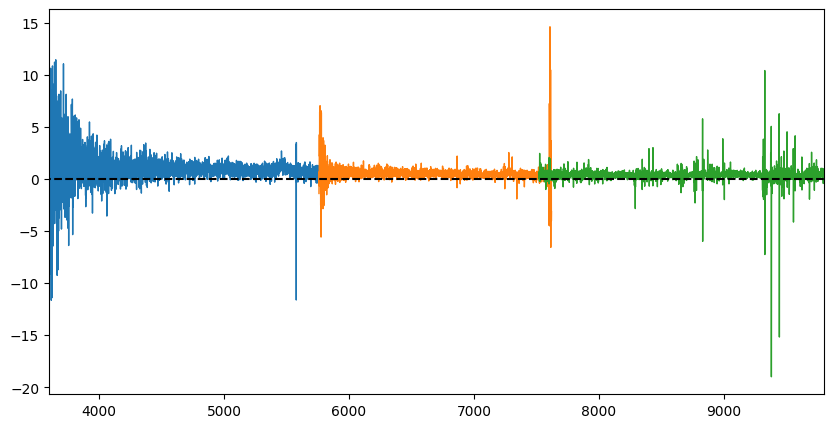

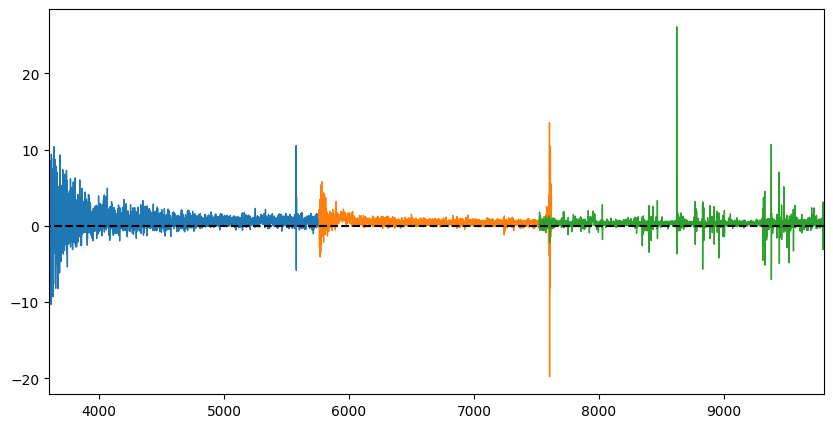

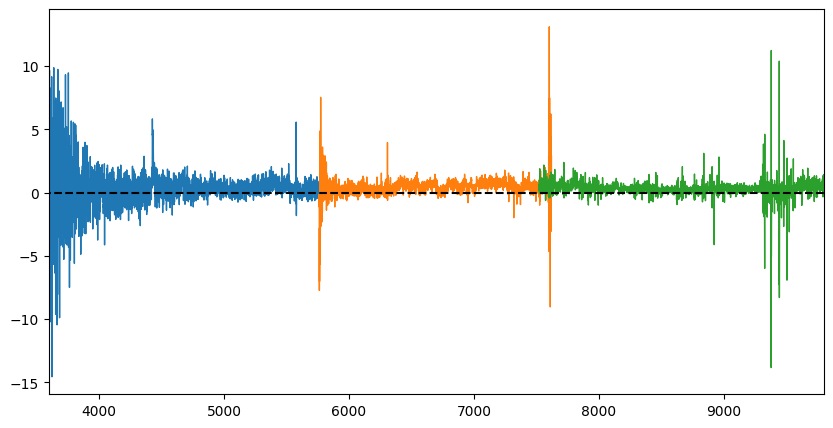

In [7]:
spec_dir = '/global/cfs/projectdirs/desi/spectro/redux/iron/healpix/'
for igal in range(10): 
    fspec = os.path.join(spec_dir, qsos['SURVEY'][igal], qsos['PROGRAM'][igal], 
                         str(qsos['HPXPIXEL'][igal])[:-2], str(qsos['HPXPIXEL'][igal]), 
                         'coadd-%s-%s-%i.fits' % (qsos['SURVEY'][igal], qsos['PROGRAM'][igal], qsos['HPXPIXEL'][igal]))
    hdulist = fits.open(fspec)
    survey = hdulist[0].header['SURVEY'].upper()
    meta = Table.read(fspec) # meta data
    target_id = hdulist[1].data['TARGETID'] # unique target ID
    
    is_gal = (target_id == qsos['TARGETID'][igal])
    assert np.sum(is_gal) == 1
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)
    sub.plot(hdulist[3].data, hdulist[4].data[is_gal][0], lw=1)
    sub.plot(hdulist[8].data, hdulist[9].data[is_gal][0], lw=1)
    sub.plot(hdulist[13].data, hdulist[14].data[is_gal][0], lw=1)
    sub.plot([0., 1e4], [0., 0.], ls='--', c='k') 
    sub.set_xlim(3.6e3, 9.8e3)
    plt.show()

In [8]:
from spender.data import desi_qso

In [9]:
desiQSO = desi_qso.DESI()

In [37]:
def prepare_spectra(hpix): 
    ''' prepare QSO spectra in healpix 
    '''
    if hpix > 100: 
        filename = os.path.join('/global/cfs/projectdirs/desi/spectro/redux/iron/healpix/main/dark/', str(hpix)[:-2], str(hpix), 
                                "coadd-main-dark-%i.fits" % hpix)
    else: 
        filename = os.path.join('/global/cfs/projectdirs/desi/spectro/redux/iron/healpix/main/dark/0/', str(hpix), 
                                "coadd-main-dark-%i.fits" % hpix)
    # read spectra file
    hdulist = fits.open(filename)
    survey = hdulist[0].header['SURVEY'].upper()
    meta = Table.read(filename) # meta data
    target_id = hdulist[1].data['TARGETID'] # unique target ID

    # read redrock file
    rr = fits.open(filename.replace("coadd", "redrock"))
    # get redshift and error
    z = torch.tensor(rr[1].data['Z'].astype(np.float32))
    zerr = torch.tensor(rr[1].data['ZERR'].astype(np.float32))

    keep = np.zeros(len(z)).astype(bool)
    for targetid in qsos['TARGETID'][qsos['HPXPIXEL'] == hpix]: 
        keep = keep | (target_id == targetid)

    # read in data
    _wave, _flux, _ivar, _mask, _res = {}, {}, {}, {}, {}
    for h in range(2, len(hdulist)):
        if "WAVELENGTH" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _wave[band] = hdulist[h].data
        if "FLUX" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _flux[band] = hdulist[h].data
        if "IVAR" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _ivar[band] = hdulist[h].data
        if "MASK" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _mask[band] = hdulist[h].data
        if "RESOLUTION" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _res[band] = hdulist[h].data

    # coadd the b, r, z arm spectra (scraped from
    # https://github.com/desihub/desispec/blob/main/py/desispec/coaddition.py#L529)
    tolerance = 0.0001  # A , tolerance
    wave = _wave["b"]
    for b in ["b", "r", "z"]:
        wave = np.append(wave, _wave[b][_wave[b] > wave[-1] + tolerance])
    nwave = wave.size
    ntarget = _flux["b"].shape[0]
    check_agreement = torch.abs(torch.from_numpy(wave) - desiQSO._wave_obs)
    if check_agreement.max() > tolerance:
        print(
            "Warning: input wavelength grids inconsistent with class variable wave_obs!"
        )
    # check alignment, caching band wavelength grid indices as we go
    windict = {}
    number_of_overlapping_cameras = np.zeros(nwave)
    for b in ["b", "r", "z"]:
        imin = np.argmin(np.abs(_wave[b][0] - wave))
        windices = np.arange(imin, imin + len(_wave[b]), dtype=int)
        dwave = _wave[b] - wave[windices]

        if np.any(np.abs(dwave) > tolerance):
            msg = "Input wavelength grids (band '{}') are not aligned. Use --lin-step or --log10-step to resample to a common grid.".format(
                b
            )
            raise ValueError(msg)
        number_of_overlapping_cameras[windices] += 1
        windict[b] = windices

    # ndiag = max of all cameras
    ndiag = 0
    for b in ["b", "r", "z"]:
        ndiag = max(ndiag, _res[b].shape[1])

    flux = np.zeros((ntarget, nwave), dtype=_flux["b"].dtype)
    ivar = np.zeros((ntarget, nwave), dtype=_ivar["b"].dtype)
    ivar_unmasked = np.zeros((ntarget, nwave), dtype=_ivar["b"].dtype)
    mask = np.zeros((ntarget, nwave), dtype=_mask["b"].dtype)
    rdata = np.zeros((ntarget, ndiag, nwave), dtype=_res["b"].dtype)

    for b in ["b", "r", "z"]:
        # indices
        windices = windict[b]

        band_ndiag = _res[b].shape[1]

        for i in range(ntarget):
            ivar_unmasked[i, windices] += np.sum(_ivar[b][i], axis=0)
            ivar[i, windices] += _ivar[b][i] * (_mask[b][i] == 0)
            flux[i, windices] += _ivar[b][i] * (_mask[b][i] == 0) * _flux[b][i]
            for r in range(band_ndiag):
                rdata[i, r + (ndiag - band_ndiag) // 2, windices] += (
                    _ivar[b][i] * _res[b][i, r]
                )

            # directly copy mask where no overlap
            jj = number_of_overlapping_cameras[windices] == 1
            mask[i, windices[jj]] = _mask[b][i][jj]

            # 'and' in overlapping regions
            jj = number_of_overlapping_cameras[windices] > 1
            mask[i, windices[jj]] = mask[i, windices[jj]] & _mask[b][i][jj]

    for i in range(ntarget):
        ok = ivar[i] > 0
        if np.sum(ok) > 0:
            flux[i][ok] /= ivar[i][ok]
        ok = ivar_unmasked[i] > 0
        if np.sum(ok) > 0:
            rdata[i][:, ok] /= ivar_unmasked[i][ok]

    # apply bitmask, remove small values
    mask = mask.astype(bool) | (ivar <= 1e-6)
    ivar[mask] = 0

    # explicit type conversion to float32 to get to little endian
    spec = torch.from_numpy(flux.astype(np.float32))
    w = torch.from_numpy(ivar.astype(np.float32))
    target_id = torch.from_numpy(target_id.astype(np.int64))

    # remove regions around skylines
    w[:, desiQSO._skyline_mask] = 0

    # normalize spectra:
    norm = torch.zeros(ntarget)
    for i in range(ntarget):
        # for redshift invariant encoder: select norm window in restframe
        wave_rest = desiQSO._wave_obs / (1 + z[i])
        # flatish region that is well observed out to z ~ 0.5
        sel = (w[i] > 0) & (wave_rest > 5300) & (wave_rest < 5850)
        if sel.count_nonzero() > 0:
            norm[i] = torch.median(spec[i][sel])
        # remove spectra (from training) for which no valid norm could be found
        if not torch.isfinite(norm[i]):
            norm[i] = 0
        else:
            spec[i] /= norm[i]
        w[i] *= norm[i]**2

    # selects finite fluxes
    #keep = keep & (spec.isfinite().sum(axis=-1) == nwave).numpy()
    print("%i keep: %d / %d"%(hpix, keep.sum(),len(keep)))
    return spec[keep], w[keep], z[keep], target_id[keep],  norm[keep], zerr[keep]

In [42]:
# save QSO spectra to batch
batch_size = 1024
counter, new_batch = 0, True
for hpix in np.unique(qsos['HPXPIXEL']): 
    spec, w, z, target_id, norm, zerr = prepare_spectra(hpix)
    if new_batch:
        batches = [spec, w, z, target_id, norm, zerr]
        new_batch = False
    else:
        batches[0] = torch.concatenate([batches[0], spec], axis=0)
        batches[1] = torch.concatenate([batches[1], w], axis=0)
        batches[2] = torch.concatenate([batches[2], z], axis=0)
        batches[3] = torch.concatenate([batches[3], target_id], axis=0)
        batches[4] = torch.concatenate([batches[4], norm], axis=0)
        batches[5] = torch.concatenate([batches[5], zerr], axis=0)

    N = batches[0].shape[0]
    print(N)
    while N > batch_size:
        batch = [_batch[:batch_size] for _batch in batches]

        print(f"saving batch {counter}")
        desiQSO.save_batch('/global/cfs/projectdirs/desi/users/chahah/spender_qso', batch, tag='qso0', counter=counter)
        counter += 1
        N -= batch_size

        batches = [_batch[batch_size:] for _batch in batches]

0 keep: 163 / 1704
163
1 keep: 148 / 1679
311
2 keep: 129 / 1456
440
3 keep: 152 / 1460
592
4 keep: 119 / 856
711
5 keep: 83 / 534
794
6 keep: 109 / 864
903
7 keep: 7 / 72
910
8 keep: 104 / 1205
1014
9 keep: 111 / 894
1125
saving batch 0
10 keep: 134 / 1278
235
11 keep: 103 / 1053
338
12 keep: 85 / 593
423
13 keep: 30 / 261
453
14 keep: 70 / 632
523
15 keep: 80 / 619
603
16 keep: 61 / 520
664
17 keep: 59 / 389
723
18 keep: 13 / 196
736
19 keep: 6 / 38
742
24 keep: 26 / 192
768
25 keep: 1 / 5
769
26 keep: 60 / 405
829
27 keep: 4 / 17
833
32 keep: 121 / 1386
954
33 keep: 106 / 1228
1060
saving batch 1
34 keep: 123 / 1096
159
35 keep: 130 / 1246
289
36 keep: 102 / 892
391
37 keep: 138 / 1349
529
38 keep: 109 / 1213
638
39 keep: 113 / 1311
751
40 keep: 96 / 1005
847
41 keep: 119 / 1132
966
42 keep: 57 / 576
1023
43 keep: 126 / 1563
1149
saving batch 2
44 keep: 125 / 1082
250
45 keep: 135 / 1434
385
46 keep: 130 / 1790
515
47 keep: 113 / 1510
628
48 keep: 140 / 1193
768
49 keep: 67 / 451
83

KeyboardInterrupt: 